In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import gc

import torch.nn as nn
import torch
from torchvision import datasets, transforms
from torch import nn, optim
import torch.nn.functional as F
import torchvision

from src import data_utils
from src.MNIST_model import MNIST_model
from src.train_config import Config as cfg
from src.MNIST_dataset import MNISTDataset
from src.custom_loss import CustomLoss
from src import train_utils

In [2]:
# initial_train_df = pd.read_csv("data/train.csv")
# print(initial_train_df.shape)
# initial_train_df.head()

# train_df = data_utils.get_dataframe_with_complete_array(initial_train_df)

# sample_train_df = train_df.sample(n=5)
# fig, ax = plt.subplots(1, 5, figsize=(15,15))
# fig.suptitle("5 Random samples", y=0.6)
# for i in range(0,5):
#     ax[i].imshow(sample_train_df["img_arr"].iloc[i], cmap="gray")
#     # ax[i].set_ylabel("xlabel") not working
#     ax[i].axis("off")
# plt.show()

In [3]:
train_set = torchvision.datasets.MNIST('/files/', train=True, download=True
                                       , transform=torchvision.transforms.Compose([
                                           torchvision.transforms.ToTensor()
                                        ]))
print(f"Train --- Shape: {list(train_set.train_data.size())} \n   - Mean: {train_set.train_data.float().mean()/255:.4f} \n   - Std: {train_set.train_data.float().std()/255:.4f}")

Train --- Shape: [60000, 28, 28] 
   - Mean: 0.1307 
   - Std: 0.3081


c:\Users\DannW\Anaconda3\envs\yolov7_env\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [4]:
transform = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  torchvision.transforms.Normalize(
    (0.1307,), (0.3081,))
])

train_dataset = MNISTDataset('/files/', train=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True)

validation_dataset = MNISTDataset('/files/', train=False, transform=transform)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=cfg.batch_size, shuffle=True)

print(f"Train: {len(train_dataset)}, Validation: {len(validation_dataset)}")

Train: 60000, Validation: 10000


In [5]:
model = MNIST_model().to(cfg.device)
optimizer = optim.SGD(model.parameters(), lr=cfg.lr, momentum=0.5)
criterion = torch.nn.CrossEntropyLoss() #CustomLoss()
model

MNIST_model(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): Dropout2d(p=0.1, inplace=False)
  )
  (GAP): AdaptiveAvgPool2d(output_size=(1, 1))
  (linear): Sequential(
    (0): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [6]:
from sklearn.metrics import accuracy_score

# if os.path.exists('results'):
#   os.system('rm -r results')

# os.mkdir('results')

def train_one_epoch(model, loader, criterion):
  model.train()
  loss_sum = 0.0
  for data, target in tqdm(loader):
    data = data.to(cfg.device)
    target = target.to(cfg.device)

    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    loss_sum += loss.item()
  print(f"Train Loss: {(loss_sum/len(loader)):.04f}")
  return loss_sum/len(loader)

def validation_one_epoch(model, loader, criterion):
  model.eval()
  loss_sum = 0
  y_true_epoch, y_pred_epoch = [], []
  with torch.no_grad():
    for data, target in tqdm(loader):
      data = data.to(cfg.device)
      target = target.to(cfg.device)

      y_pred = model(data)
      loss_sum += criterion(y_pred, target).item()
      y_pred = F.softmax(y_pred, dim=1)
      y_true_epoch.append(target.cpu().numpy())
      y_pred_epoch.append(np.argmax(y_pred.cpu().numpy(), axis=1))

  y_true_epoch = np.concatenate(y_true_epoch, axis=0)
  y_pred_epoch = np.concatenate(y_pred_epoch, axis=0)
  scores = accuracy_score(y_true_epoch, y_pred_epoch) #[average_precision_score(y_true_epoch[:,i], y_pred_epoch[:,i]) for i in range(cfg.num_classes)]
  mean_score = np.mean(scores)
  print(f"Validation loss: {loss_sum/len(loader):.4f}, Accuracy: {mean_score:.05f}")

  return loss_sum/len(loader), mean_score, y_true_epoch, y_pred_epoch

Epoch: 0


100%|██████████| 235/235 [00:26<00:00,  8.74it/s]


Train Loss: 2.1768


100%|██████████| 40/40 [00:03<00:00, 13.21it/s]


Validation loss: 2.0143, Accuracy: 0.26010

Saving Model ...
Epoch: 1


100%|██████████| 235/235 [00:20<00:00, 11.25it/s]


Train Loss: 1.8998


100%|██████████| 40/40 [00:03<00:00, 13.21it/s]


Validation loss: 1.6464, Accuracy: 0.40890

Saving Model ...
Epoch: 2


100%|██████████| 235/235 [00:20<00:00, 11.42it/s]


Train Loss: 1.5836


100%|██████████| 40/40 [00:03<00:00, 12.30it/s]


Validation loss: 1.3572, Accuracy: 0.54150

Saving Model ...
Epoch: 3


100%|██████████| 235/235 [00:19<00:00, 11.92it/s]


Train Loss: 1.2991


100%|██████████| 40/40 [00:02<00:00, 13.78it/s]


Validation loss: 0.9951, Accuracy: 0.73380

Saving Model ...
Epoch: 4


100%|██████████| 235/235 [00:17<00:00, 13.16it/s]


Train Loss: 1.0189


100%|██████████| 40/40 [00:02<00:00, 14.96it/s]


Validation loss: 0.7508, Accuracy: 0.80240

Saving Model ...
Epoch: 5


100%|██████████| 235/235 [00:19<00:00, 12.24it/s]


Train Loss: 0.8216


100%|██████████| 40/40 [00:02<00:00, 14.55it/s]


Validation loss: 0.6948, Accuracy: 0.78760
Epoch: 6


100%|██████████| 235/235 [00:18<00:00, 12.51it/s]


Train Loss: 0.6851


100%|██████████| 40/40 [00:02<00:00, 14.85it/s]


Validation loss: 0.4582, Accuracy: 0.88600

Saving Model ...
Epoch: 7


100%|██████████| 235/235 [00:18<00:00, 12.55it/s]


Train Loss: 0.5885


100%|██████████| 40/40 [00:02<00:00, 14.79it/s]


Validation loss: 0.4084, Accuracy: 0.89720

Saving Model ...
Epoch: 8


100%|██████████| 235/235 [00:18<00:00, 12.65it/s]


Train Loss: 0.5246


100%|██████████| 40/40 [00:02<00:00, 13.62it/s]


Validation loss: 0.3613, Accuracy: 0.90430

Saving Model ...
Epoch: 9


100%|██████████| 235/235 [00:18<00:00, 12.55it/s]


Train Loss: 0.4686


100%|██████████| 40/40 [00:02<00:00, 14.91it/s]


Validation loss: 0.3171, Accuracy: 0.92080

Saving Model ...
Epoch: 10


100%|██████████| 235/235 [00:18<00:00, 12.73it/s]


Train Loss: 0.4290


100%|██████████| 40/40 [00:02<00:00, 13.75it/s]


Validation loss: 0.2869, Accuracy: 0.92540

Saving Model ...
Epoch: 11


100%|██████████| 235/235 [00:18<00:00, 12.47it/s]


Train Loss: 0.3982


100%|██████████| 40/40 [00:02<00:00, 15.10it/s]


Validation loss: 0.2706, Accuracy: 0.93140

Saving Model ...
Epoch: 12


100%|██████████| 235/235 [00:18<00:00, 12.79it/s]


Train Loss: 0.3737


100%|██████████| 40/40 [00:02<00:00, 14.01it/s]


Validation loss: 0.2551, Accuracy: 0.93190

Saving Model ...
Epoch: 13


100%|██████████| 235/235 [00:18<00:00, 12.82it/s]


Train Loss: 0.3481


100%|██████████| 40/40 [00:02<00:00, 14.81it/s]


Validation loss: 0.2377, Accuracy: 0.93310

Saving Model ...
Epoch: 14


100%|██████████| 235/235 [00:18<00:00, 12.75it/s]


Train Loss: 0.3318


100%|██████████| 40/40 [00:02<00:00, 13.51it/s]


Validation loss: 0.2415, Accuracy: 0.93410

Saving Model ...
Epoch: 15


100%|██████████| 235/235 [00:17<00:00, 13.15it/s]


Train Loss: 0.3130


100%|██████████| 40/40 [00:02<00:00, 14.25it/s]


Validation loss: 0.2029, Accuracy: 0.94180

Saving Model ...
Epoch: 16


100%|██████████| 235/235 [00:18<00:00, 12.66it/s]


Train Loss: 0.3016


100%|██████████| 40/40 [00:02<00:00, 14.42it/s]


Validation loss: 0.2020, Accuracy: 0.94510

Saving Model ...
Epoch: 17


100%|██████████| 235/235 [00:18<00:00, 12.70it/s]


Train Loss: 0.2918


100%|██████████| 40/40 [00:02<00:00, 14.13it/s]


Validation loss: 0.2012, Accuracy: 0.94540

Saving Model ...
Epoch: 18


100%|██████████| 235/235 [00:18<00:00, 12.55it/s]


Train Loss: 0.2790


100%|██████████| 40/40 [00:02<00:00, 15.13it/s]


Validation loss: 0.1844, Accuracy: 0.94560

Saving Model ...
Epoch: 19


100%|██████████| 235/235 [00:18<00:00, 12.40it/s]


Train Loss: 0.2725


100%|██████████| 40/40 [00:02<00:00, 15.11it/s]


Validation loss: 0.1753, Accuracy: 0.95210

Saving Model ...
Epoch: 20


100%|██████████| 235/235 [00:18<00:00, 13.02it/s]


Train Loss: 0.2640


100%|██████████| 40/40 [00:02<00:00, 14.45it/s]


Validation loss: 0.1693, Accuracy: 0.95250

Saving Model ...
Epoch: 21


100%|██████████| 235/235 [00:18<00:00, 13.00it/s]


Train Loss: 0.2551


100%|██████████| 40/40 [00:02<00:00, 14.95it/s]


Validation loss: 0.1626, Accuracy: 0.95480

Saving Model ...
Epoch: 22


100%|██████████| 235/235 [00:18<00:00, 12.82it/s]


Train Loss: 0.2486


100%|██████████| 40/40 [00:02<00:00, 13.51it/s]


Validation loss: 0.1637, Accuracy: 0.95440
Epoch: 23


100%|██████████| 235/235 [00:18<00:00, 12.71it/s]


Train Loss: 0.2432


100%|██████████| 40/40 [00:02<00:00, 14.92it/s]


Validation loss: 0.1647, Accuracy: 0.95460
Epoch: 24


100%|██████████| 235/235 [00:18<00:00, 12.67it/s]


Train Loss: 0.2366


100%|██████████| 40/40 [00:02<00:00, 15.10it/s]


Validation loss: 0.1592, Accuracy: 0.95490

Saving Model ...
Epoch: 25


100%|██████████| 235/235 [00:19<00:00, 12.10it/s]


Train Loss: 0.2314


100%|██████████| 40/40 [00:02<00:00, 14.65it/s]


Validation loss: 0.1600, Accuracy: 0.95540

Saving Model ...
Epoch: 26


100%|██████████| 235/235 [00:17<00:00, 13.20it/s]


Train Loss: 0.2271


100%|██████████| 40/40 [00:02<00:00, 15.02it/s]


Validation loss: 0.1564, Accuracy: 0.95400
Epoch: 27


100%|██████████| 235/235 [00:17<00:00, 13.11it/s]


Train Loss: 0.2225


100%|██████████| 40/40 [00:02<00:00, 14.08it/s]


Validation loss: 0.1446, Accuracy: 0.95980

Saving Model ...
Epoch: 28


100%|██████████| 235/235 [00:18<00:00, 12.57it/s]


Train Loss: 0.2186


100%|██████████| 40/40 [00:02<00:00, 14.42it/s]


Validation loss: 0.1559, Accuracy: 0.95920
Epoch: 29


100%|██████████| 235/235 [00:22<00:00, 10.42it/s]


Train Loss: 0.2178


100%|██████████| 40/40 [00:03<00:00, 13.03it/s]


Validation loss: 0.1365, Accuracy: 0.96030

Saving Model ...
Epoch: 30


100%|██████████| 235/235 [00:26<00:00,  9.01it/s]


Train Loss: 0.2103


100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Validation loss: 0.1414, Accuracy: 0.95880
Epoch: 31


100%|██████████| 235/235 [00:18<00:00, 12.88it/s]


Train Loss: 0.2054


100%|██████████| 40/40 [00:02<00:00, 15.16it/s]


Validation loss: 0.1419, Accuracy: 0.95920
Epoch: 32


100%|██████████| 235/235 [00:20<00:00, 11.42it/s]


Train Loss: 0.2048


100%|██████████| 40/40 [00:03<00:00, 11.89it/s]


Validation loss: 0.1349, Accuracy: 0.96050

Saving Model ...
Epoch: 33


100%|██████████| 235/235 [00:21<00:00, 11.02it/s]


Train Loss: 0.2014


100%|██████████| 40/40 [00:02<00:00, 13.80it/s]


Validation loss: 0.1381, Accuracy: 0.96130

Saving Model ...
Epoch: 34


100%|██████████| 235/235 [00:18<00:00, 12.38it/s]


Train Loss: 0.1987


100%|██████████| 40/40 [00:02<00:00, 13.67it/s]


Validation loss: 0.1287, Accuracy: 0.96380

Saving Model ...
Epoch: 35


100%|██████████| 235/235 [00:17<00:00, 13.28it/s]


Train Loss: 0.1980


100%|██████████| 40/40 [00:02<00:00, 14.77it/s]


Validation loss: 0.1234, Accuracy: 0.96480

Saving Model ...
Epoch: 36


100%|██████████| 235/235 [00:18<00:00, 12.94it/s]


Train Loss: 0.1905


100%|██████████| 40/40 [00:02<00:00, 15.07it/s]


Validation loss: 0.1261, Accuracy: 0.96450
Epoch: 37


100%|██████████| 235/235 [00:18<00:00, 12.96it/s]


Train Loss: 0.1945


100%|██████████| 40/40 [00:02<00:00, 14.78it/s]


Validation loss: 0.1363, Accuracy: 0.96280
Epoch: 38


100%|██████████| 235/235 [00:18<00:00, 12.84it/s]


Train Loss: 0.1893


100%|██████████| 40/40 [00:02<00:00, 15.12it/s]


Validation loss: 0.1259, Accuracy: 0.96280
Epoch: 39


100%|██████████| 235/235 [00:18<00:00, 12.40it/s]


Train Loss: 0.1871


100%|██████████| 40/40 [00:02<00:00, 14.11it/s]


Validation loss: 0.1300, Accuracy: 0.96530

Saving Model ...
Epoch: 40


100%|██████████| 235/235 [00:18<00:00, 12.80it/s]


Train Loss: 0.1852


100%|██████████| 40/40 [00:02<00:00, 14.00it/s]


Validation loss: 0.1257, Accuracy: 0.96440
Epoch: 41


100%|██████████| 235/235 [00:18<00:00, 12.47it/s]


Train Loss: 0.1842


100%|██████████| 40/40 [00:02<00:00, 14.10it/s]


Validation loss: 0.1232, Accuracy: 0.96350
Epoch: 42


100%|██████████| 235/235 [00:17<00:00, 13.32it/s]


Train Loss: 0.1808


100%|██████████| 40/40 [00:02<00:00, 15.11it/s]


Validation loss: 0.1177, Accuracy: 0.96510
Epoch: 43


100%|██████████| 235/235 [00:18<00:00, 12.68it/s]


Train Loss: 0.1777


100%|██████████| 40/40 [00:02<00:00, 15.07it/s]


Validation loss: 0.1142, Accuracy: 0.96760

Saving Model ...
Epoch: 44


100%|██████████| 235/235 [00:19<00:00, 12.32it/s]


Train Loss: 0.1780


100%|██████████| 40/40 [00:02<00:00, 13.69it/s]


Validation loss: 0.1266, Accuracy: 0.96160
Epoch: 45


100%|██████████| 235/235 [00:18<00:00, 12.83it/s]


Train Loss: 0.1754


100%|██████████| 40/40 [00:02<00:00, 15.00it/s]


Validation loss: 0.1113, Accuracy: 0.96650
Epoch: 46


100%|██████████| 235/235 [00:18<00:00, 12.61it/s]


Train Loss: 0.1742


100%|██████████| 40/40 [00:02<00:00, 15.83it/s]


Validation loss: 0.1092, Accuracy: 0.96850

Saving Model ...
Epoch: 47


100%|██████████| 235/235 [00:16<00:00, 14.51it/s]


Train Loss: 0.1739


100%|██████████| 40/40 [00:02<00:00, 16.14it/s]


Validation loss: 0.1121, Accuracy: 0.96690
Epoch: 48


100%|██████████| 235/235 [00:19<00:00, 12.33it/s]


Train Loss: 0.1704


100%|██████████| 40/40 [00:02<00:00, 13.96it/s]


Validation loss: 0.1132, Accuracy: 0.96740
Epoch: 49


100%|██████████| 235/235 [00:17<00:00, 13.49it/s]


Train Loss: 0.1697


100%|██████████| 40/40 [00:02<00:00, 15.21it/s]


Validation loss: 0.1056, Accuracy: 0.96870

Saving Model ...
Epoch: 50


100%|██████████| 235/235 [00:20<00:00, 11.56it/s]


Train Loss: 0.1683


100%|██████████| 40/40 [00:03<00:00, 10.56it/s]


Validation loss: 0.1087, Accuracy: 0.96920

Saving Model ...
Epoch: 51


100%|██████████| 235/235 [00:20<00:00, 11.32it/s]


Train Loss: 0.1641


100%|██████████| 40/40 [00:02<00:00, 14.98it/s]


Validation loss: 0.1081, Accuracy: 0.96950

Saving Model ...
Epoch: 52


100%|██████████| 235/235 [00:18<00:00, 12.93it/s]


Train Loss: 0.1667


100%|██████████| 40/40 [00:02<00:00, 14.46it/s]


Validation loss: 0.1128, Accuracy: 0.96780
Epoch: 53


100%|██████████| 235/235 [00:18<00:00, 12.74it/s]


Train Loss: 0.1649


100%|██████████| 40/40 [00:02<00:00, 14.94it/s]


Validation loss: 0.1061, Accuracy: 0.96960

Saving Model ...
Epoch: 54


100%|██████████| 235/235 [00:18<00:00, 12.71it/s]


Train Loss: 0.1632


100%|██████████| 40/40 [00:03<00:00, 12.32it/s]


Validation loss: 0.1064, Accuracy: 0.96980

Saving Model ...
Epoch: 55


100%|██████████| 235/235 [00:17<00:00, 13.35it/s]


Train Loss: 0.1626


100%|██████████| 40/40 [00:02<00:00, 14.39it/s]


Validation loss: 0.1076, Accuracy: 0.97010

Saving Model ...
Epoch: 56


100%|██████████| 235/235 [00:17<00:00, 13.41it/s]


Train Loss: 0.1600


100%|██████████| 40/40 [00:02<00:00, 14.24it/s]


Validation loss: 0.1068, Accuracy: 0.96930
Epoch: 57


100%|██████████| 235/235 [00:18<00:00, 12.81it/s]


Train Loss: 0.1608


100%|██████████| 40/40 [00:02<00:00, 15.14it/s]


Validation loss: 0.1078, Accuracy: 0.96950
Epoch: 58


100%|██████████| 235/235 [00:17<00:00, 13.36it/s]


Train Loss: 0.1585


100%|██████████| 40/40 [00:02<00:00, 15.22it/s]


Validation loss: 0.1011, Accuracy: 0.97070

Saving Model ...
Epoch: 59


100%|██████████| 235/235 [00:18<00:00, 12.88it/s]


Train Loss: 0.1560


100%|██████████| 40/40 [00:02<00:00, 14.51it/s]


Validation loss: 0.1026, Accuracy: 0.96970
Epoch: 60


100%|██████████| 235/235 [00:19<00:00, 11.82it/s]


Train Loss: 0.1545


100%|██████████| 40/40 [00:04<00:00,  9.83it/s]


Validation loss: 0.0989, Accuracy: 0.97100

Saving Model ...
Epoch: 61


100%|██████████| 235/235 [00:20<00:00, 11.32it/s]


Train Loss: 0.1572


100%|██████████| 40/40 [00:03<00:00, 11.44it/s]


Validation loss: 0.1010, Accuracy: 0.97130

Saving Model ...
Epoch: 62


100%|██████████| 235/235 [00:19<00:00, 12.00it/s]


Train Loss: 0.1544


100%|██████████| 40/40 [00:02<00:00, 15.01it/s]


Validation loss: 0.1020, Accuracy: 0.97100
Epoch: 63


100%|██████████| 235/235 [00:18<00:00, 12.85it/s]


Train Loss: 0.1534


100%|██████████| 40/40 [00:02<00:00, 13.57it/s]


Validation loss: 0.1006, Accuracy: 0.97120
Epoch: 64


100%|██████████| 235/235 [00:18<00:00, 12.46it/s]


Train Loss: 0.1526


100%|██████████| 40/40 [00:02<00:00, 14.98it/s]


Validation loss: 0.1029, Accuracy: 0.97040
Epoch: 65


100%|██████████| 235/235 [00:18<00:00, 12.46it/s]


Train Loss: 0.1526


100%|██████████| 40/40 [00:03<00:00, 13.02it/s]


Validation loss: 0.0989, Accuracy: 0.97210

Saving Model ...
Epoch: 66


100%|██████████| 235/235 [00:19<00:00, 12.21it/s]


Train Loss: 0.1519


100%|██████████| 40/40 [00:02<00:00, 13.58it/s]


Validation loss: 0.1012, Accuracy: 0.97240

Saving Model ...
Epoch: 67


100%|██████████| 235/235 [00:18<00:00, 12.61it/s]


Train Loss: 0.1488


100%|██████████| 40/40 [00:02<00:00, 13.50it/s]


Validation loss: 0.0965, Accuracy: 0.97160
Epoch: 68


100%|██████████| 235/235 [00:19<00:00, 12.25it/s]


Train Loss: 0.1477


100%|██████████| 40/40 [00:02<00:00, 14.65it/s]


Validation loss: 0.1010, Accuracy: 0.97120
Epoch: 69


100%|██████████| 235/235 [00:18<00:00, 12.42it/s]


Train Loss: 0.1482


100%|██████████| 40/40 [00:02<00:00, 14.37it/s]


Validation loss: 0.0960, Accuracy: 0.97370

Saving Model ...
Epoch: 70


100%|██████████| 235/235 [00:19<00:00, 12.18it/s]


Train Loss: 0.1468


100%|██████████| 40/40 [00:02<00:00, 14.67it/s]


Validation loss: 0.0941, Accuracy: 0.97260
Epoch: 71


100%|██████████| 235/235 [00:18<00:00, 12.64it/s]


Train Loss: 0.1454


100%|██████████| 40/40 [00:02<00:00, 14.21it/s]


Validation loss: 0.0931, Accuracy: 0.97370
Epoch: 72


100%|██████████| 235/235 [00:19<00:00, 12.14it/s]


Train Loss: 0.1460


100%|██████████| 40/40 [00:02<00:00, 14.56it/s]


Validation loss: 0.0953, Accuracy: 0.97260
Epoch: 73


100%|██████████| 235/235 [00:20<00:00, 11.64it/s]


Train Loss: 0.1440


100%|██████████| 40/40 [00:02<00:00, 14.20it/s]


Validation loss: 0.0962, Accuracy: 0.97200
Epoch: 74


100%|██████████| 235/235 [00:19<00:00, 12.13it/s]


Train Loss: 0.1420


100%|██████████| 40/40 [00:03<00:00, 11.39it/s]


Validation loss: 0.0932, Accuracy: 0.97220
Epoch: 75


100%|██████████| 235/235 [00:17<00:00, 13.47it/s]


Train Loss: 0.1437


100%|██████████| 40/40 [00:02<00:00, 15.68it/s]


Validation loss: 0.0908, Accuracy: 0.97360
Epoch: 76


100%|██████████| 235/235 [00:17<00:00, 13.60it/s]


Train Loss: 0.1402


100%|██████████| 40/40 [00:02<00:00, 15.69it/s]


Validation loss: 0.1043, Accuracy: 0.97350
Epoch: 77


100%|██████████| 235/235 [00:17<00:00, 13.59it/s]


Train Loss: 0.1403


100%|██████████| 40/40 [00:02<00:00, 15.59it/s]


Validation loss: 0.0882, Accuracy: 0.97470

Saving Model ...
Epoch: 78


100%|██████████| 235/235 [00:17<00:00, 13.44it/s]


Train Loss: 0.1399


100%|██████████| 40/40 [00:02<00:00, 15.72it/s]


Validation loss: 0.0893, Accuracy: 0.97510

Saving Model ...
Epoch: 79


100%|██████████| 235/235 [00:16<00:00, 14.00it/s]


Train Loss: 0.1395


100%|██████████| 40/40 [00:02<00:00, 15.81it/s]


Validation loss: 0.0907, Accuracy: 0.97460
Epoch: 80


100%|██████████| 235/235 [00:16<00:00, 14.05it/s]


Train Loss: 0.1388


100%|██████████| 40/40 [00:02<00:00, 15.71it/s]


Validation loss: 0.0922, Accuracy: 0.97520

Saving Model ...
Epoch: 81


100%|██████████| 235/235 [00:17<00:00, 13.58it/s]


Train Loss: 0.1374


100%|██████████| 40/40 [00:02<00:00, 15.86it/s]


Validation loss: 0.0873, Accuracy: 0.97580

Saving Model ...
Epoch: 82


100%|██████████| 235/235 [00:17<00:00, 13.77it/s]


Train Loss: 0.1355


100%|██████████| 40/40 [00:02<00:00, 15.62it/s]


Validation loss: 0.0882, Accuracy: 0.97550
Epoch: 83


100%|██████████| 235/235 [00:16<00:00, 13.92it/s]


Train Loss: 0.1355


100%|██████████| 40/40 [00:02<00:00, 15.52it/s]


Validation loss: 0.0905, Accuracy: 0.97400
Epoch: 84


100%|██████████| 235/235 [00:17<00:00, 13.65it/s]


Train Loss: 0.1345


100%|██████████| 40/40 [00:02<00:00, 15.81it/s]


Validation loss: 0.0919, Accuracy: 0.97510
Epoch: 85


100%|██████████| 235/235 [00:16<00:00, 14.03it/s]


Train Loss: 0.1341


100%|██████████| 40/40 [00:02<00:00, 15.63it/s]


Validation loss: 0.0857, Accuracy: 0.97550
Epoch: 86


100%|██████████| 235/235 [00:16<00:00, 14.32it/s]


Train Loss: 0.1342


100%|██████████| 40/40 [00:02<00:00, 16.22it/s]


Validation loss: 0.0861, Accuracy: 0.97530
Epoch: 87


100%|██████████| 235/235 [00:17<00:00, 13.80it/s]


Train Loss: 0.1317


100%|██████████| 40/40 [00:02<00:00, 15.68it/s]


Validation loss: 0.0848, Accuracy: 0.97570
Epoch: 88


100%|██████████| 235/235 [00:16<00:00, 14.36it/s]


Train Loss: 0.1322


100%|██████████| 40/40 [00:02<00:00, 15.94it/s]


Validation loss: 0.0939, Accuracy: 0.97450
Epoch: 89


100%|██████████| 235/235 [00:17<00:00, 13.72it/s]


Train Loss: 0.1313


100%|██████████| 40/40 [00:02<00:00, 13.90it/s]


Validation loss: 0.0897, Accuracy: 0.97540


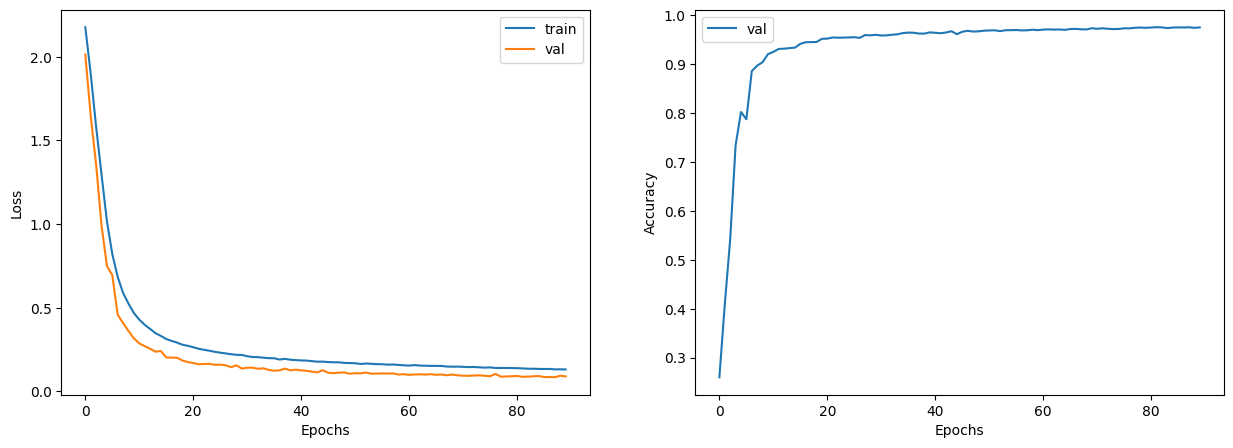

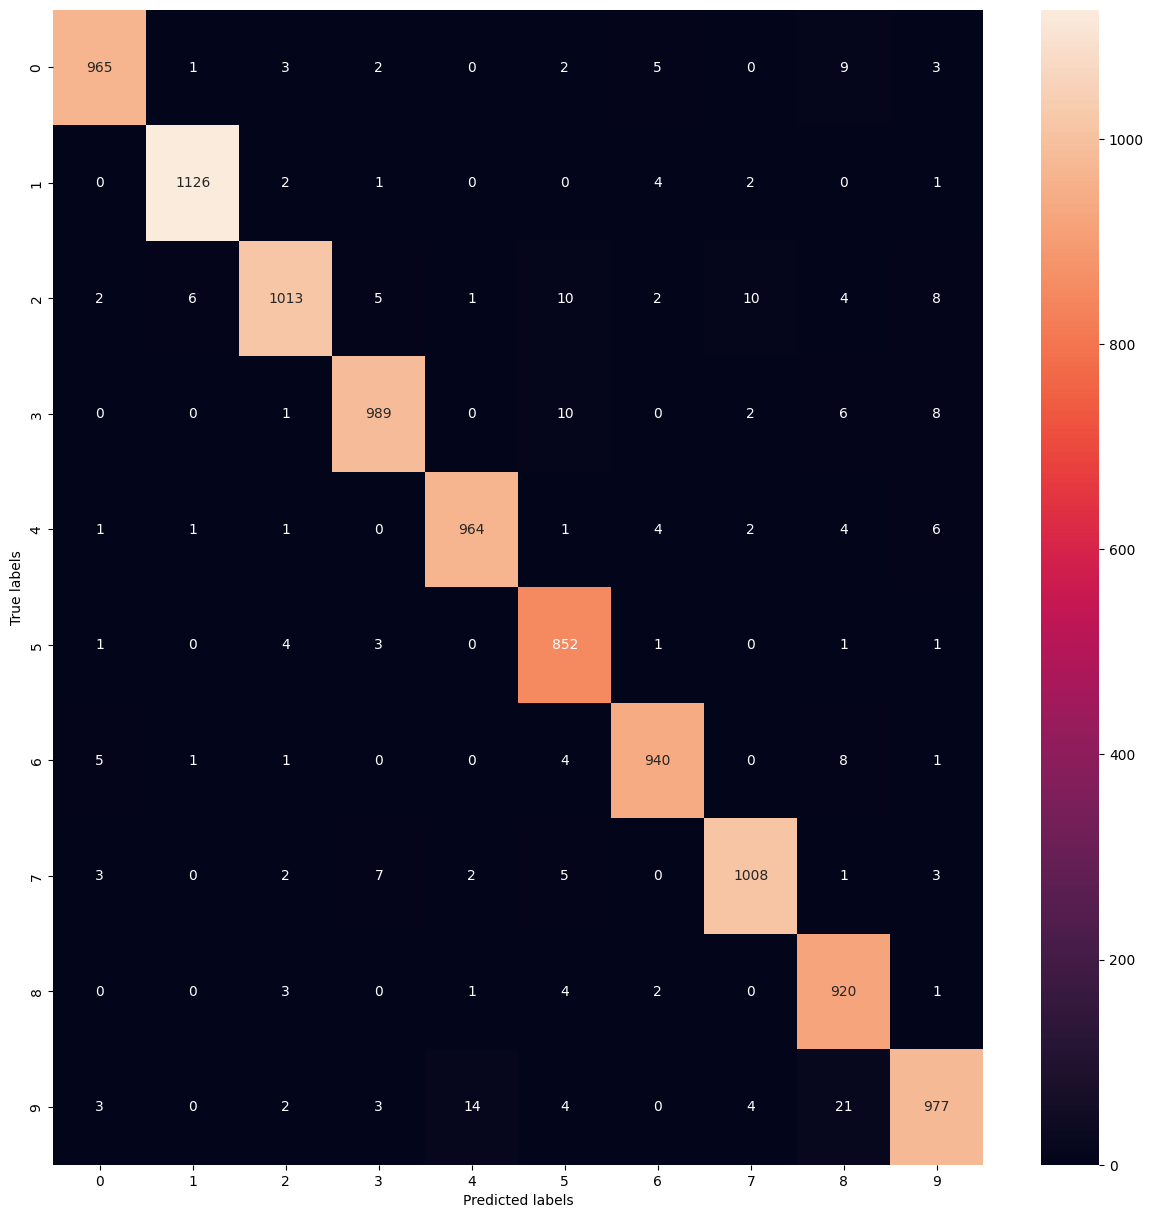

{9: 51, 2: 48, 3: 27, 0: 25, 7: 23, 4: 20, 6: 20, 5: 11, 8: 11, 1: 10}


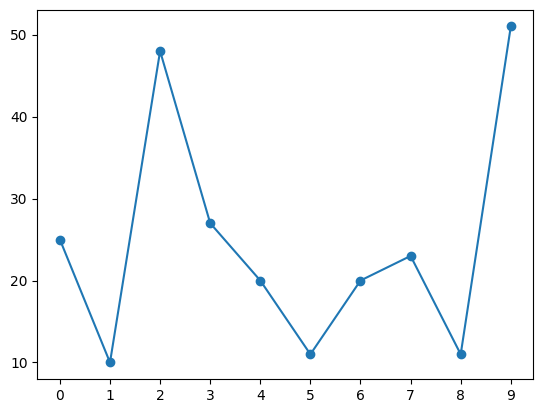

22769

In [7]:
# Training 
max_score = 0.0
loss = {"train": [], "val":[]}
acc = {"train": [], "val":[]}
for n_iter in range(1, cfg.n_iters+1):
  for epoch in range(cfg.num_epochs):
    print("="*50)
    print(f"Epoch: {epoch}")
    train_loss = train_one_epoch(model, train_dataloader, criterion)
    val_loss, score, labels, y_preds = validation_one_epoch(model, validation_dataloader, criterion)
    loss["train"].append(train_loss), loss["val"].append(val_loss), acc["val"].append(score)

    if score > max_score:
      max_score = np.mean(score)
      torch.save(model.state_dict(), "results/best_model_state_"+cfg.model_name+".h5")
      print("\nSaving Model ...")
    print("="*50)

  train_utils.plot_losses(loss, acc)
  conf_matrix = train_utils.get_and_plot_matrix_confusion(y_preds, labels)
  worst_classes_l = train_utils.get_worst_classes(conf_matrix)
  criterion = CustomLoss(worst_classes_l=worst_classes_l)

gc.collect()